<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>CET Template Notebook</b> <br>
Contact author(s): <i>Author Name</i> <br>
Last verified to run: <i>yyyy-mm-dd</i> <br>
LSST Science Piplines version: Weekly <i>yyyy_xx</i> <br>
Container Size: <i>medium</i> <br>
Targeted learning level: <i>beginner</i> <br>

**Description:** Example of a tutorial notebook exercise to explore deblender products. Would like to access the footprint, and plot deblended source centroids on top of the segmentation map (footprint) as a demonstration of how the deblender works.

In [1]:
# general python packages
import numpy as np
import os
import matplotlib.pyplot as plt
import gc
import time
plt.style.use('tableau-colorblind10')

# LSST package for TAP queries
from lsst.rsp import get_tap_service, retrieve_query

# LSST package for Butler queries
import lsst.daf.butler as Butler

# Familiar stack packages
from lsst.geom import Box2I, Box2D, Point2I, Point2D, Extent2I, Extent2D
from lsst.afw.image import Exposure, Image, PARENT

# These may be less familiar objects dealing with multi-band data products
from lsst.afw.image import MultibandExposure, MultibandImage
from lsst.afw.detection import MultibandFootprint, Footprint

# LSST package for image display
import lsst.afw.display as afwDisplay
#import lsst.geom
import lsst.geom as geom

# Astropy imports
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel
from astropy.visualization import make_lupton_rgb
from photutils import * #SkyCircularAperture
from astropy.nddata import Cutout2D

# Pipeline tasks
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask
afwDisplay.setDefaultBackend('matplotlib')

**Description:** Set up a function for plotting cutouts

In [2]:
# A function and settings  to plot a cutout from tutorial notebook 03a


def cutout_coadd(butler, ra, dec, band='r', datasetType='deepCoadd',
                 skymap=None, cutoutSideLength=51, **kwargs):
    """
    Produce a cutout from a coadd at the given ra, dec position.

    Adapted from DC2 tutorial notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Servant providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    band: string
        Filter of the image to load
    datasetType: string ['deepCoadd']
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional]
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("skyMap")

    # Look up the tract, patch for the RA, Dec
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    xy = geom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    patch = tractInfo.getSequentialPatchIndex(patchInfo)

    coaddId = {'tract': tractInfo.getId(), 'patch': patch, 'band': band}
    parameters = {'bbox': bbox}

    cutout_image = butler.get(datasetType, parameters=parameters,
                              dataId=coaddId)

    return cutout_image

####  Select most blended objects

In [3]:
service = get_tap_service()
assert service is not None
assert service.baseurl == "https://data.lsst.cloud/api/tap"

query = "SELECT objectId, x, y, coord_ra, coord_dec, detect_isPrimary, deblend_nChild, deblend_skipped, detect_fromBlend, " + \
        "detect_isDeblendedModelSource, detect_isDeblendedSource, detect_isIsolated, parentObjectId, footprintArea, z_blendedness, " + \
        "tract, patch " + \
        "FROM dp02_dc2_catalogs.Object " + \
        "WHERE deblend_nChild > 10 " # Number of children this object has (defaults to 0)

max_rec = 50
results_maxblend = service.search(query, maxrec=max_rec)
#assert len(results1) == max_rec

# Convert the results to an Astropy table, then
tab_maxblend = results_maxblend.to_table()


objectId,x,y,coord_ra,coord_dec,detect_isPrimary,deblend_nChild,deblend_skipped,detect_fromBlend,detect_isDeblendedModelSource,detect_isDeblendedSource,detect_isIsolated,parentObjectId,footprintArea,z_blendedness,tract,patch
,pix,pix,deg,deg,,,,,,,,,pix,,,
int64,float64,float64,float64,float64,bool,int32,bool,bool,bool,bool,bool,int64,int32,float64,int64,int64
1251253028502113421,20039.0,1570.0,62.5798282,-44.5737961,False,20,False,False,False,False,False,0,9616,0.0,2903,4
1251253028502113361,16888.3892624,1523.873648,62.8255096,-44.5771048,False,20,False,False,False,False,False,0,7717,0.0,2903,4
1251253028502113385,18051.925817,1449.9735466,62.7347471,-44.5809953,False,12,False,False,False,False,False,0,3989,0.0,2903,4
1251253028502113560,17131.1131989,1610.5461199,62.8066002,-44.5722516,False,12,False,False,False,False,False,0,3651,0.0,2903,4
1251253028502113215,19895.8671191,1368.7825591,62.5909024,-44.5850182,False,20,False,False,False,False,False,0,10056,0.0,2903,4
1251253028502113788,19068.0705187,1675.7842883,62.6555813,-44.5682064,False,11,False,False,False,False,False,0,4838,0.0,2903,4
1251253028502113633,19813.1862481,1670.1472657,62.59748,-44.5683044,False,17,False,False,False,False,False,0,5476,0.0,2903,4
1251253028502113660,19423.6299753,1624.8826927,62.6278368,-44.5709348,False,12,False,False,False,False,False,0,2648,0.0,2903,4


#### Make a plot of one of the blends

1248675773246610542


<Figure size 3000x3000 with 0 Axes>

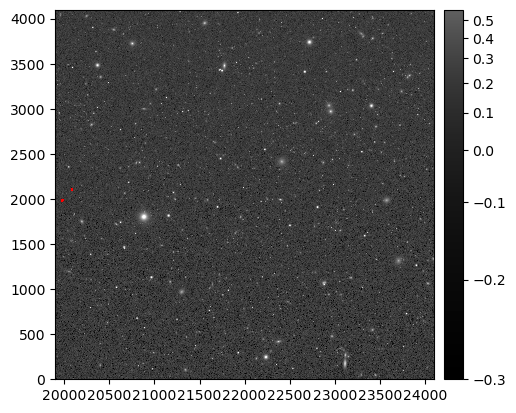

In [43]:
# prepare to do the cutout from tutorial notebook 03
config = 'dp02'
collection = '2.2i/runs/DP0.2'
butler = Butler.Butler(config, collections=collection)

datasetType = "deepCoadd"


# this is a good one:
#1329731770446283558	4574.5498478	5486.0082516	72.3165407	-42.8674071	True	0	False	True	True	True	False	1329731770446253832	4867	0.9493601	3085	8

#sel_objid = 1248675773246610542, tract 2897 and patch 5 is a good one
#1248675773246610542	23484.4969535	3210.1552014	50.1089143	-44.4812763	False	13	False	False	False	False	False	0	3435	0.0	2897	5

tract = 2897
patch = 5

sel_objid = 1248675773246610542 #tab_maxblend[0]['objectId']
ra = 50.1089143
dec = -44.4812763
x = 23484.4969535
y = 3210.1552014
print(sel_objid)


#dataId = {'tract': tab_maxblend['tract'][0], 'band': 'i', 'patch': tab_maxblend['patch'][0] }  
dataId = {'tract': tract, 'band': 'i', 'patch': patch }  
blend_coadd = butler.get(datasetType, **dataId)

deblend_metadata = butler.get("deblend_metadata", **dataId)

# Take a look at the image of the patch
plt.figure(figsize=(30,30))
afw_display = afwDisplay.Display()
afw_display.setMaskTransparency(100)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(blend_coadd.getMaskedImage()) # what does getMaskedImage do?

# We use display buffering to avoid re-drawing the image
#  after each source is plotted
with afw_display.Buffering():
    for i in range(len(tab_maxblend)):
        afw_display.dot('+', tab_maxblend[i]['x'], tab_maxblend[i]['y'], ctype=afwDisplay.RED)

        #WTF IS GOING ON HERE WITH THE PLOTTING

In [44]:
%%time


#query_children = "SELECT objectId, x, y, coord_ra, coord_dec, detect_isPrimary, deblend_nChild, deblend_skipped, detect_fromBlend, " + \
#        "detect_isDeblendedModelSource, detect_isDeblendedSource, detect_isIsolated, parentObjectId, footprintArea, z_blendedness, " + \
#        "tract, patch " + \
#        "FROM dp02_dc2_catalogs.Object " + \
#        "WHERE patch = " + str(tab_maxblend[0]['patch']) + " AND tract = " + str(tab_maxblend[0]['tract']) +  \
#        "AND parentObjectID = " + str(sel_objid)
    
query_children = "SELECT ObjectId, x, y, coord_ra, coord_dec, detect_isPrimary, deblend_nChild, deblend_skipped, detect_fromBlend, " + \
        "detect_isDeblendedModelSource, detect_isDeblendedSource, detect_isIsolated, parentObjectId, footprintArea, z_blendedness, " + \
        "tract, patch " + \
        "FROM dp02_dc2_catalogs.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec ), " + \
        "CIRCLE('ICRS', " + str(ra) + ", " + str(dec) + ", 0.01)) = 1 "
#results = service.search(query, maxrec=1000)
    
    
results_children = service.search(query_children, maxrec=10000)
tab_children = results_children.to_table()

whc = np.where(tab_children['parentObjectId'] == sel_objid)[0]
#print('FOUNDtx[0], table['ObjectId'][tx[0]])

# search for everything with parentobjID as one of these then you should get n_deblend sources.
# when talkign to data production: best to have a well constrained problem. here's this one thing
# here's what i'm trying to do, what is the next step. faster response this way.
# make a new notebook where i outline one source example. ask 1 question at a time. 10min

CPU times: user 28.9 ms, sys: 2.37 ms, total: 31.3 ms
Wall time: 221 ms


In [46]:

tab_children[whc]

ObjectId,x,y,coord_ra,coord_dec,detect_isPrimary,deblend_nChild,deblend_skipped,detect_fromBlend,detect_isDeblendedModelSource,detect_isDeblendedSource,detect_isIsolated,parentObjectId,footprintArea,z_blendedness,tract,patch
,pix,pix,deg,deg,,,,,,,,,pix,,,
int64,float64,float64,float64,float64,bool,int32,bool,bool,bool,bool,bool,int64,int32,float64,int64,int64
1248675773246640706,23512.9343389,3205.7072499,50.1066973,-44.4815091,True,0,False,True,True,True,False,1248675773246610542,3190,0.4453317,2897,5
1248675773246640705,23483.3200083,3246.0487119,50.1090308,-44.4792832,True,0,False,True,True,True,False,1248675773246610542,3658,0.1195687,2897,5
1248675773246640704,23466.9451452,3233.6287998,50.110297,-44.4799812,True,0,False,True,True,True,False,1248675773246610542,4329,0.0246939,2897,5
1248675773246640703,23484.4939823,3210.1595245,50.1089145,-44.481276,True,0,False,True,True,True,False,1248675773246610542,5840,-0.0120574,2897,5
1248675773246640715,23463.0054624,3244.5699979,50.1106113,-44.4793755,True,0,False,True,True,True,False,1248675773246610542,2388,0.8006751,2897,5
1248675773246640714,23503.2067846,3201.5918329,50.1074517,-44.4817425,True,0,False,True,True,True,False,1248675773246610542,2791,0.9565817,2897,5
1248675773246640713,23478.9219813,3227.3238199,50.1093602,-44.4803255,True,0,False,True,True,True,False,1248675773246610542,4270,1.0,2897,5
1248675773246640712,23465.7187079,3197.3916488,50.1103673,-44.4819947,True,0,False,True,True,True,False,1248675773246610542,3235,1.0,2897,5


In [47]:
#sel_objid = tab_maxblend[0]['objectId']
#sel_objid

<Figure size 3000x3000 with 0 Axes>

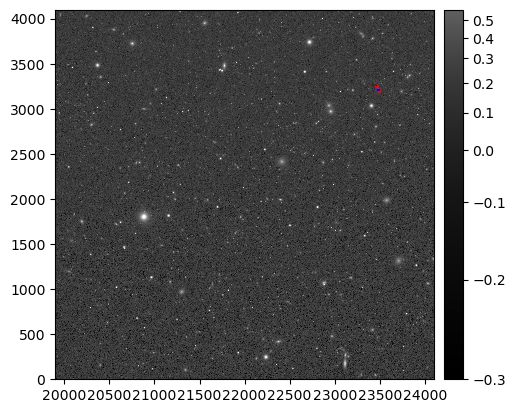

In [48]:
# Take a look at the image of the patch
plt.figure(figsize=(30,30))
afw_display = afwDisplay.Display()
afw_display.setMaskTransparency(100)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(blend_coadd.getMaskedImage()) # what does getMaskedImage do?

# We use display buffering to avoid re-drawing the image
#  after each source is plotted
with afw_display.Buffering():
    for i in range(len(tab_children[whc])):
        afw_display.dot('+', tab_children[whc][i]['x'], tab_children[whc][i]['y'], ctype=afwDisplay.RED)

#afw_display.dot('+', tab_maxblend[0]['x'], tab_maxblend[0]['y'], ctype=afwDisplay.BLUE)
afw_display.dot('+', x, y, ctype=afwDisplay.BLUE)

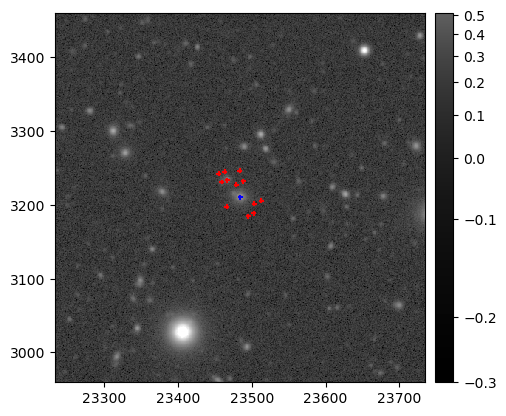

In [49]:
cutout_image = cutout_coadd(butler, ra,dec, band='i', datasetType='deepCoadd',
                            cutoutSideLength=501)

wcs = cutout_image.getWcs()

x0 = float(cutout_image.getX0())
y0 = float(cutout_image.getY0())
width = cutout_image.getWidth()
height = cutout_image.getHeight()

xcorners = [x0, x0+width, x0+width, x0]
ycorners = [y0, y0, y0+width, y0+width]

ra_corners = []
dec_corners = []

for i in range(len(xcorners)):
    radec = wcs.pixelToSky(xcorners[i], ycorners[i])
    ra_corners.append(radec.getRa().asDegrees())
    dec_corners.append(radec.getDec().asDegrees())


fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(cutout_image.image)
with display.Buffering():
    for i in range(len(tab_children[whc])):
        display.dot('+', tab_children[whc][i]['x'], tab_children[whc][i]['y'], ctype=afwDisplay.RED)

display.dot('+', x, y, ctype=afwDisplay.BLUE)
plt.show()